imports

In [67]:
%matplotlib inline
import pygame
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

classe Sound

In [68]:
{
    "tags": [
        "hide_input",
    ]
}
class mySound:
    def __init__(self, f0 = 440, c = 340):
        self.f0 = f0  # frequency in Hertz                                                                                                                  
        self.c = c   # speed in m/s  

buffer audio

In [69]:
class AudioBuffer:
    def __init__(self, N, sample_rate, delta_time, bits):
        self.bits = bits
        self.delta_time = delta_time # durata (in secondi) di un intervallo                                                                                 
        self.N = N # numero di intervalli da considerare                                                                                                    
        self.sample_rate = sample_rate # frequenza di campionamento                                                                                         
        self.n_samples = int(round(delta_time*sample_rate))  # dati campionati in ogni singolo intervallo                                                   
        self.phase_acc = 0  # differenza di fase cumulata                                                                                                   
        self.audio_buffer = np.zeros((N*self.n_samples), dtype = np.int16)  # Audio buffer                                                                  
        self.max_sample = 2**(bits - 1) - 1
        
    def updateAudioBuffer(self, i,f):  # i e' l'intervallo in considerazione, con la frequenza f                                                            
        for s in range(self.n_samples):
            tt = float(s)/self.sample_rate    # time in seconds                                                                                             
            #grab the x-coordinate of the sine wave at a given time, while constraining the sample to what our mixer is set to with "bits"                  
            self.audio_buffer[i*self.n_samples+s] = int(round(self.max_sample*math.sin(self.phase_acc + 2*math.pi*f*tt)))

        phase = (f*self.delta_time - np.floor(f*self.delta_time))*2*np.pi
        self.phase_acc += phase

    def makeSoundWithAudioBuffer(self):
        #the number of channels specified here is NOT                                                                                                       
        #the channels talked about here http://www.pygame.org/docs/ref/mixer.html#pygame.mixer.get_num_channels                                             
        pygame.mixer.pre_init(self.sample_rate, -self.bits, 1)
        pygame.init()
        sound = pygame.sndarray.make_sound(self.audio_buffer)
        sound.play()

        wait_time = int(self.N*self.delta_time +1)*1000
        pygame.time.wait(wait_time)
        pygame.quit()

classe Particle

In [70]:
class Particle:
    d2r =  math.pi / 180;

    def __init__(self, x0=0, y0=0, v=0, angle=0):
        self.x0 = x0  # initial (t=0 s) x pos in m                                                                                                          
        self.y0 = y0  # initial (t=0 s) y pos in m                                                                                                          
        self.v = v   # constant speed in m/s                                                                                                                
        self.angle = angle   # speed direction in degree                                                                                                    
        self.vx = self.v*math.cos(self.angle*self.d2r)
        self.vy = self.v*math.sin(self.angle*self.d2r)

    # return x-pos at time t                                                                                                                                
    def get_x(self, t):
        return self.x0 + self.vx*t
    # return y-pos at time t                                                                                                                                
    def get_y(self, t):
        return self.y0 + self.vy*t

buffer grafico

In [71]:
class GraphBuffer:
    # data_to_plot[0,i] = t                                                                                                                                 
    # data_to_plot[1,i] = Delta_t                                                                                                                           
    # data_to_plot[2,i] = A_xt                                                                                                                              
    # data_to_plot[3,i] = A_yt                                                                                                                              
    # data_to_plot[4,i] = A_x                                                                                                                               
    # data_to_plot[5,i] = A_y                                                                                                                               
    # data_to_plot[6,i] = B_x                                                                                                                               
    # data_to_plot[7,i] = B_y                                                                                                                               
    # data_to_plot[8,i] = f                                                                                                                                 

    def __init__(self, N):
        self.data_to_plot = np.empty([9,N], dtype = np.float32)
        self.last_used = 0
        self.Ndata = N

    def updateGraphBuffer(self, new_data):
        assert(self.last_used < self.Ndata)
        for j in range(0,9):
            self.data_to_plot[j,self.last_used] = new_data[j]
        self.last_used += 1

    def plotGraphBuffer(self):
        fig, (ax1, ax2) = plt.subplots(2)

        ax1.set_title('posizioni')
        ax1.set_xlabel('$\it{x}$ [m]')
        ax1.set_ylabel('$\it{y}$ [m]')
        ax1.plot(self.data_to_plot[2], self.data_to_plot[3])
        ax1.plot(self.data_to_plot[6], self.data_to_plot[7])

        ax2.set_title('frequenza')
        ax2.set_xlabel('$\it{t}$ [s]')
        ax2.set_ylabel('$\it{f}$ [Hz]')
        ax2.plot(self.data_to_plot[0], self.data_to_plot[8])

        fig.tight_layout()
        plt.show(block = False)



funzione principale

In [72]:
def updatePosAndFreq(t, A, B, S, i):
    A_x = A.get_x(t)
    A_y = A.get_y(t)

    B_x = B.get_x(t)
    B_y = B.get_y(t)

    d_0x = B_x - A_x
    d_0y = B_y - A_y
    d_0 = math.sqrt(d_0x**2 + d_0y**2)

    delta = (d_0*S.c)**2 - (d_0x*A.vy - d_0y*A.vx)**2

    Delta_t = ( -d_0x*A.vx - d_0y*A.vy + math.sqrt(delta) )/(S.c**2 - A.v**2)

    A_xt = A.get_x(t-Delta_t)
    A_yt = A.get_y(t-Delta_t)

    d_x = B_x - A_xt;
    d_y = B_y - A_yt;
    d = math.sqrt(d_x**2 + d_y**2);

    v_Ad = (A.vx*d_x + A.vy*d_y)/d;
    v_Bd = (B.vx*d_x + B.vy*d_y)/d;

    f = (  (S.c - v_Bd) / (S.c-v_Ad)  ) * S.f0;

    updated_data = tuple((t, Delta_t, A_xt, A_yt, A_x, A_y, B_x, B_y, f))

    # f is updated_data[8]                                                                                                                                  
    return updated_data


    return f

main

In [73]:
def main():
    S = mySound(f0 = 440, c = 340)

    x_A0 = 20
    y_A0 = 0
    v_A = 30
    angle_A = 50
    A = Particle(x_A0, y_A0, v_A, angle_A)

    x_B0 = 70
    y_B0 = 0
    v_B = 40
    angle_B = 110
    B = Particle(x_B0, y_B0, v_B, angle_B)

    start_time = 0  # ALWAYS                                                                                                                                
    end_time = 3
    N = 10000
    delta_time = (end_time - start_time)/N

    # data buffer to sound                                                                                                                                  
    bits = 16
    sample_rate = 44100   # sampling rate, Hz, must be integer                                                                                              
    buf = AudioBuffer(N, sample_rate, delta_time, bits)

    # data to be plotted                                                                                                                                    
    graph_data = GraphBuffer(N)

    #  for (double t = start_time; t<end_time; t+=delta_time)                                                                                               
    for i in range(0,N):
        t = i*delta_time
        updated_data  = updatePosAndFreq(t, A, B, S, i)
        f = updated_data[8]

        graph_data.updateGraphBuffer(updated_data)
        buf.updateAudioBuffer(i,f)


    graph_data.plotGraphBuffer()
    buf.makeSoundWithAudioBuffer()

finalmente

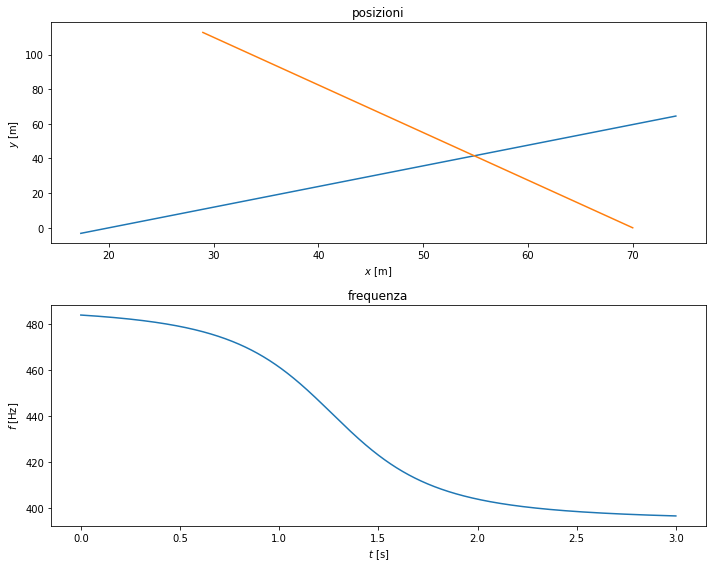

In [74]:
main()